In [450]:
import math
import mne
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]

from mne.decoding import UnsupervisedSpatialFilter
from sklearn.decomposition import PCA, FastICA

from sklearn.model_selection import train_test_split, StratifiedKFold, StratifiedShuffleSplit

from sklearn.linear_model import LogisticRegression

import seaborn as sns

import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import mne
from mne import io, pick_types, read_events, Epochs
# from mne.datasets import sample
from mne.preprocessing import Xdawn
from mne.decoding import Vectorizer
from mne.viz import tight_layout

import os
import os.path as op

matplotlib.rcParams['figure.figsize'] = (15.0, 10.0)
matplotlib.rcParams.update({'font.size': 15})

In [177]:
#search and store names of all the files in folder in array
def arrayFiles(path):
    folderContent = os.listdir(path)
    fifFiles = []
    for i in folderContent :
        fifFiles.append(path + "/" + i)
    
    return fifFiles

In [178]:
#concatenate path to name of each file and store in array for reading in data
path = '/Volumes/flash64/EpochedEEG'
allFifFiles = arrayFiles(path)
#print(allFifFiles)

In [179]:
#master arraya to hold all scores for multiple subject file
classification_score = []

In [180]:
epoch = mne.read_epochs(allFifFiles[0],preload=True)

Reading /Volumes/flash64/EpochedEEG/20131216_1441_epo.fif ...
    Found the data of interest:
        t =    -199.22 ...     500.00 ms
        0 CTF compensation matrices available
5424 matching events found
Applying baseline correction (mode: mean)
5424 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


In [129]:
epoch_copy = epoch.copy().crop(0,0.5)


In [130]:
#events = mne.pick_events(epoch.events, exclude=[133, 134])

In [131]:
events = epoch_copy.events
print(events[:,-1])

[131  31 144 ...   1 131 134]


In [9]:
#plotting the data to see it work.
#epoch_copy.plot(n_channels=20)

In [10]:
event_id = epoch_copy.event_id

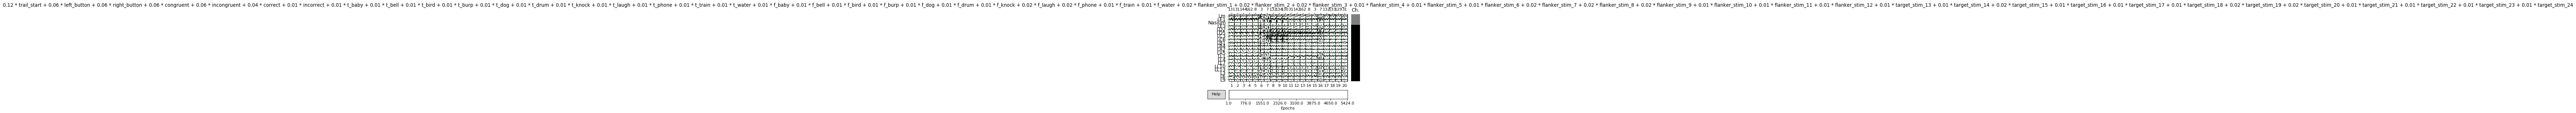

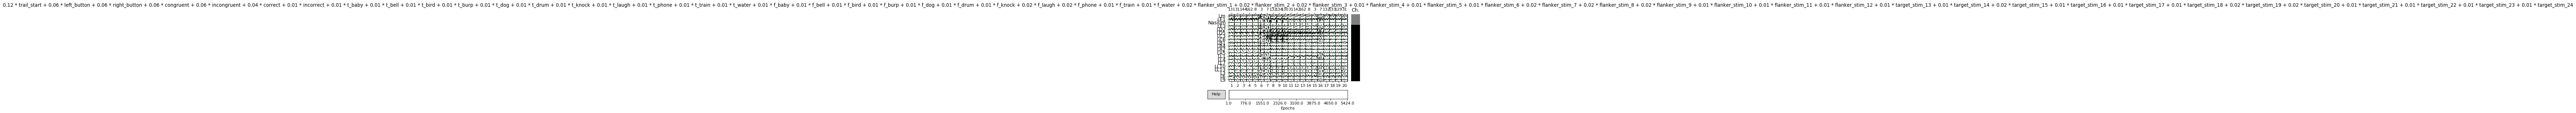

In [12]:
epoch_copy.plot()

In [432]:
epoch_copy10 = epoch.copy()

In [433]:
epoch_copy10.events.shape

(5424, 3)

In [429]:
#group events into trials.
def get_trials(epochObj):
    trials = []
    current_trial = []
    for event in epochObj.events:
        if event[-1] == 31 and current_trial != []:
            trials.append(current_trial)
            current_trial = []
            current_trial.append(event)
        else:
            current_trial.append(event)
    trials.append(current_trial)
    
    epochObj.events = trials
    return epochObj.events

In [401]:
get_trials(epoch_copy6)

[[array([2411,    0,  131])],
 [array([2580,    0,   31]),
  array([2581,   31,  144]),
  array([2583,    0,  162]),
  array([2593,    0,    8]),
  array([2718,    0,    3]),
  array([2847,    0,    7]),
  array([3200,    0,  132]),
  array([3201,  132,  134]),
  array([3203,    0,  130])],
 [array([3669,    0,   31]),
  array([3671,    0,  142]),
  array([3672,  142,  162]),
  array([3682,    0,    8]),
  array([3807,    0,    3]),
  array([3936,    0,    7]),
  array([4298,    0,  132]),
  array([4299,  132,  133]),
  array([4301,    0,  129])],
 [array([4487,    0,   31]),
  array([4489,    0,  142]),
  array([4491,    0,  162]),
  array([4500,    0,    8]),
  array([4625,    0,    3]),
  array([4754,    0,    7]),
  array([4792,    0,  132]),
  array([4884,    0,  133])],
 [array([5030,    0,   31]),
  array([5032,    0,  142]),
  array([5033,  142,  162]),
  array([5043,    0,    8]),
  array([5168,    0,    3]),
  array([5297,    0,    7]),
  array([5340,    0,  132]),
  array([5

In [406]:
np.concatenate(epoch_copy6.events).shape

(5424, 3)

In [434]:
"""
Find trials that have congruent flanker and target concepts and label the flanker, target, and flanker ids same 
flanker concept and target concept are same concept if target concept id is exactly 20 less than flanker concept id
"""

def find_congruent_incongruent(epochObj):
    trials = get_trials(epochObj)
    for trial in trials:
        stim_combo = []
        t_concept = 0
        f_concept = 0
        for event in trial:
            if event[-1] in (155,156,157,158,159,160,161,162,163,164,165):
                f_concept = event
            if(event[-1] <=24):
                stim_combo.append(event)
            if event[-1] in (135,136,137,138,139,140,141,142,143,144,145):
                t_concept = event
        
        if type(f_concept) != int and type(t_concept) != int:
            f = int(f_concept[-1])
            t = int(t_concept[-1])
            if f == t + 20:
                for event in stim_combo:
                    event[-1] = 100
            elif f != t + 20:
                for event in stim_combo:
                    event[-1] = 200
    
        
    epochObj.events = np.concatenate(trials)
    return epochObj.events
        

In [436]:
#Trials starts from event 31 and ends on event 130.
find_congruent_incongruent(epoch_copy10)[0:10]

array([[2411,    0,  131],
       [2580,    0,   31],
       [2581,   31,  144],
       [2583,    0,  162],
       [2593,    0,  200],
       [2718,    0,  200],
       [2847,    0,  200],
       [3200,    0,  132],
       [3201,  132,  134],
       [3203,    0,  130]])

In [438]:
epoch_copy10.events.shape

(5424, 3)

In [439]:
"""Select only events with ids 100 or 200, we want to use only flanker,target, and flanker events
    100 means the three event combinations are semantically congruent and 200 means they are not.
"""
twoEventEpoch = epoch_copy10[(epoch_copy10.events[:,-1]==100) | (epoch_copy10.events[:,-1]==200)].copy()

In [445]:
twoEventEpoch.get_data().shape

(1920, 129, 180)

In [447]:
twoEventEpoch.events.shape

(1920, 3)

In [483]:
twoEventEpoch.events[0:20]

array([[2593,    0,  200],
       [2718,    0,  200],
       [2847,    0,  200],
       [3682,    0,  100],
       [3807,    0,  100],
       [3936,    0,  100],
       [4500,    0,  100],
       [4625,    0,  100],
       [4754,    0,  100],
       [5043,    0,  100],
       [5168,    0,  100],
       [5297,    0,  100],
       [5581,    0,  200],
       [5706,    0,  200],
       [5835,    0,  200],
       [6120,    0,  100],
       [6244,    0,  100],
       [6374,    0,  100],
       [6658,    0,  200],
       [6778,    0,  200]])

In [ ]:
"""
This function classifies congruent vs non-congruent using Logistic Regression
"""

In [456]:
def classify(congr_incongr_obj):
    features = congr_incongr_obj.get_data()
    target=congr_incongr_obj.events[:,-1]

    clf = make_pipeline(Vectorizer(),StandardScaler(),LogisticRegression())


    #cross validation
    cv = StratifiedKFold(n_splits=2,shuffle=True)
    score = []
    for train,test in cv.split(features,target):
        X_train = features[train]; y_train = target[train] 
        X_test = features[test];   y_test = target[test]

        clf.fit(X_train,y_train)
        score.append(clf.score(X_test,y_test))
    
    print("mean classification score", np.mean(score))
    classification_score.append(np.mean(score))

In [457]:
classify(twoEventEpoch)

mean classification score 0.5010416666666666


In [ ]:
#Classify 4 subject files using Logistic Regression

In [ ]:
"""
Classify 4 files
"""

In [458]:
for i in range(1,5):
    epoch = mne.read_epochs(allFifFiles[i],preload=True)
    epoch_copy1 = epoch.copy()
    
    find_congruent_incongruent(epoch_copy1)
    congr_incongr_obj = epoch_copy1[(epoch_copy1.events[:,-1]==100) | (epoch_copy1.events[:,-1]==200)].copy()
    classify(congr_incongr_obj)

Reading /Volumes/flash64/EpochedEEG/20140205_1114_epo.fif ...
    Found the data of interest:
        t =    -199.22 ...     500.00 ms
        0 CTF compensation matrices available
5379 matching events found
Applying baseline correction (mode: mean)
5379 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
mean classification score 0.4859375
Reading /Volumes/flash64/EpochedEEG/20140205_1230_epo.fif ...
    Found the data of interest:
        t =    -199.22 ...     500.00 ms
        0 CTF compensation matrices available
5565 matching events found
Applying baseline correction (mode: mean)
5565 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
mean classification score 0.5065656565656566
Reading /Volumes/flash64/EpochedEEG/20140206_1029_epo.fif ...
    Found the data of interest:
        t =    -199.22 ...     500.00 ms
        0 CTF compensation matrices available


In [459]:
print(classification_score)


[0.5010416666666666, 0.4859375, 0.5065656565656566, 0.48177083333333337, 0.5020263424518744]


Text(0.5,1,'Logistic Regression')

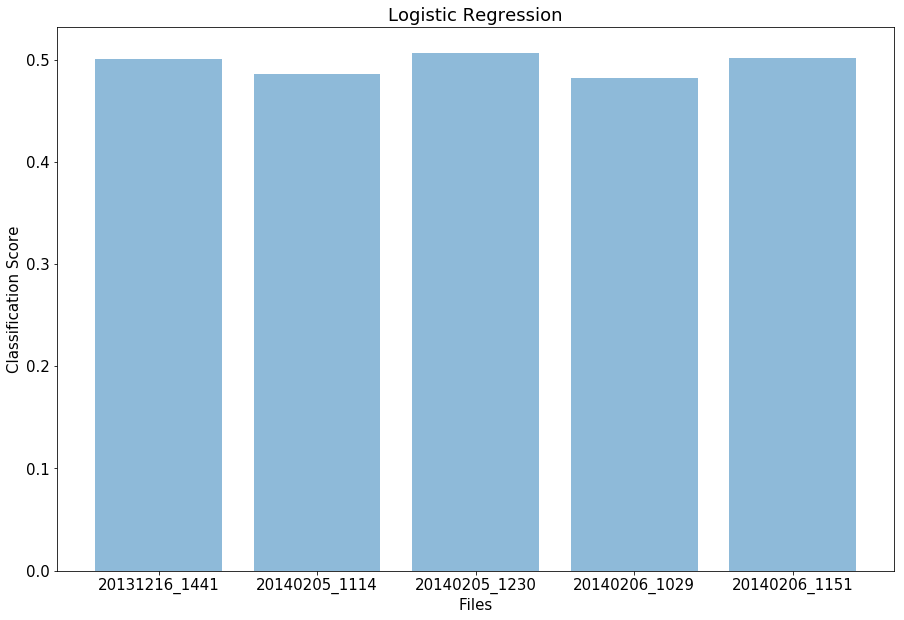

In [460]:
subj = ['20131216_1441','20140205_1114','20140205_1230','20140206_1029','20140206_1151']
pos = np.arange(len(subj))
plt.bar(pos, classification_score, align='center', alpha=0.5)
plt.xticks(pos, subj)
plt.xlabel("Files")
plt.ylabel('Classification Score')
plt.title('Logistic Regression')

(array([2., 0., 0., 1., 2.]),
 array([0.48177083, 0.4867298 , 0.49168876, 0.49664773, 0.50160669,
        0.50656566]),
 <a list of 5 Patch objects>)

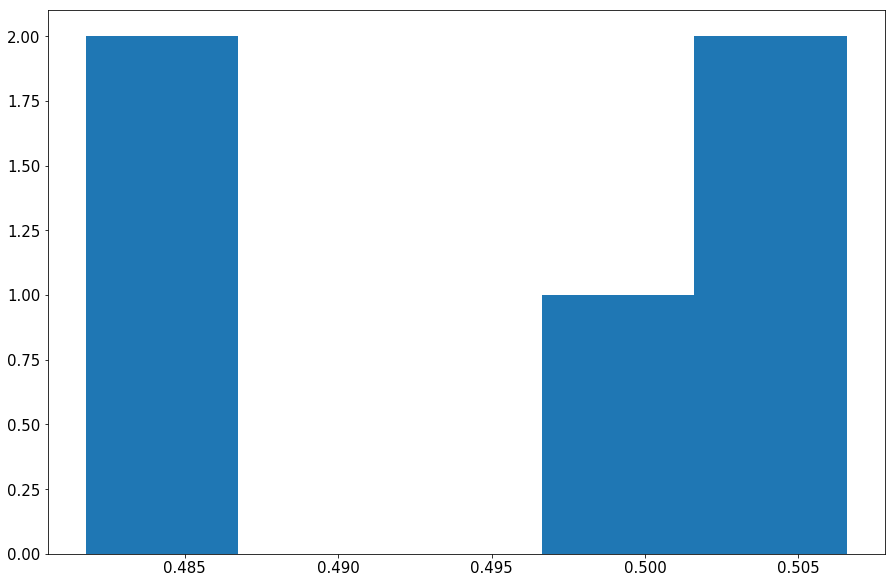

In [464]:
#histogram scores
plt.hist(classification_score,bins=5)

In [468]:
classification_score2 = []  # Will hold Mean classification scores for subject files using SVC

In [469]:
classification_score3 = []  # Will hold Mean classification scores for subject files using LDA

In [472]:
def classify2(congr_incongr_obj,classifier,classify_arr):
    features = congr_incongr_obj.get_data()
    target=congr_incongr_obj.events[:,-1]

    clf = make_pipeline(Vectorizer(),StandardScaler(),classifier)


    #cross validation
    cv = StratifiedKFold(n_splits=2,shuffle=True)
    score = []
    for train,test in cv.split(features,target):
        X_train = features[train]; y_train = target[train] 
        X_test = features[test];   y_test = target[test]

        clf.fit(X_train,y_train)
        score.append(clf.score(X_test,y_test))
    
    print("mean classification score", np.mean(score))
    classify_arr.append(np.mean(score))

In [473]:
for i in range(0,2):
    epoch = mne.read_epochs(allFifFiles[i],preload=True)
    epoch_copy = epoch.copy()
    
    #Find incongruent/congruent events and label them accordingly
    find_congruent_incongruent(epoch_copy)
    #Select events that are 100 or 200 labeled
    congr_incongr_obj = epoch_copy[(epoch_copy.events[:,-1]==100) | (epoch_copy.events[:,-1]==200)].copy()
    #classify by passing in the filtered epoch object, the classifier, and an empty array.
    classify2(congr_incongr_obj,SVC(),classification_score2)
    
    

Reading /Volumes/flash64/EpochedEEG/20131216_1441_epo.fif ...
    Found the data of interest:
        t =    -199.22 ...     500.00 ms
        0 CTF compensation matrices available
5424 matching events found
Applying baseline correction (mode: mean)
5424 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
mean classification score 0.4984375
Reading /Volumes/flash64/EpochedEEG/20140205_1114_epo.fif ...
    Found the data of interest:
        t =    -199.22 ...     500.00 ms
        0 CTF compensation matrices available
5379 matching events found
Applying baseline correction (mode: mean)
5379 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
mean classification score 0.4942708333333333


In [475]:
print(classification_score2)

[0.4984375, 0.4942708333333333]


Text(0.5,1,'SVM')

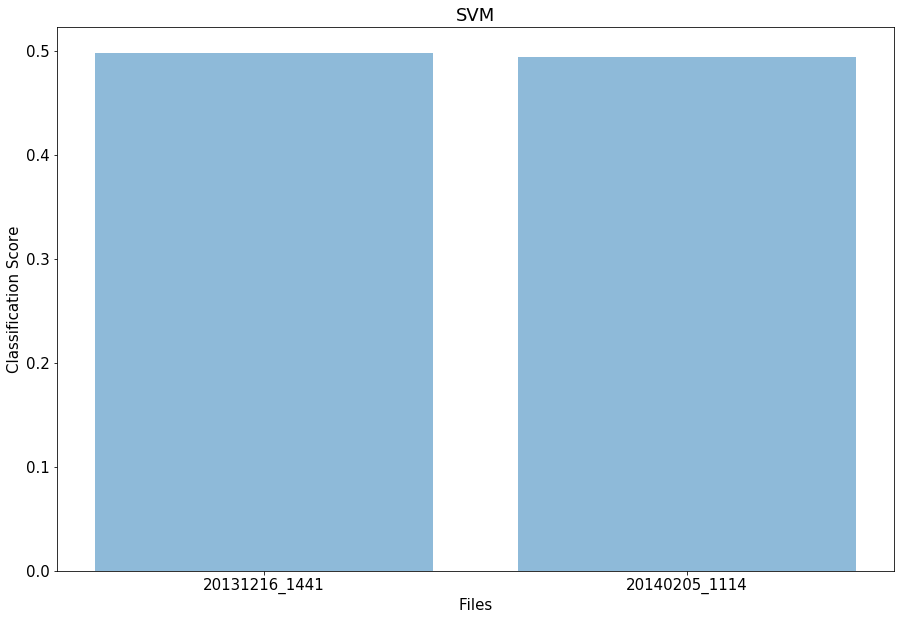

In [476]:
subj = ['20131216_1441','20140205_1114']
pos = np.arange(len(subj))
plt.bar(pos, classification_score2, align='center', alpha=0.5)
plt.xticks(pos, subj)
plt.xlabel("Files")
plt.ylabel('Classification Score')
plt.title('SVM')

In [ ]:
#classify data using LDA

In [478]:

for i in range(0,3):
    epoch = mne.read_epochs(allFifFiles[i],preload=True)
    epoch_copy = epoch.copy()
    
    find_congruent_incongruent(epoch_copy)
    congr_incongr_obj = epoch_copy[(epoch_copy.events[:,-1]==100) | (epoch_copy.events[:,-1]==200)].copy()
    classify2(congr_incongr_obj,LDA(),classification_score3)
    

Reading /Volumes/flash64/EpochedEEG/20131216_1441_epo.fif ...
    Found the data of interest:
        t =    -199.22 ...     500.00 ms
        0 CTF compensation matrices available
5424 matching events found
Applying baseline correction (mode: mean)
5424 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


mean classification score 0.4895833333333333
Reading /Volumes/flash64/EpochedEEG/20140205_1114_epo.fif ...
    Found the data of interest:
        t =    -199.22 ...     500.00 ms
        0 CTF compensation matrices available
5379 matching events found
Applying baseline correction (mode: mean)
5379 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


mean classification score 0.49583333333333335
Reading /Volumes/flash64/EpochedEEG/20140205_1230_epo.fif ...
    Found the data of interest:
        t =    -199.22 ...     500.00 ms
        0 CTF compensation matrices available
5565 matching events found
Applying baseline correction (mode: mean)
5565 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


mean classification score 0.4939393939393939


In [479]:
print(classification_score3)

[0.4895833333333333, 0.49583333333333335, 0.4939393939393939]


Text(0.5,1,'LDA')

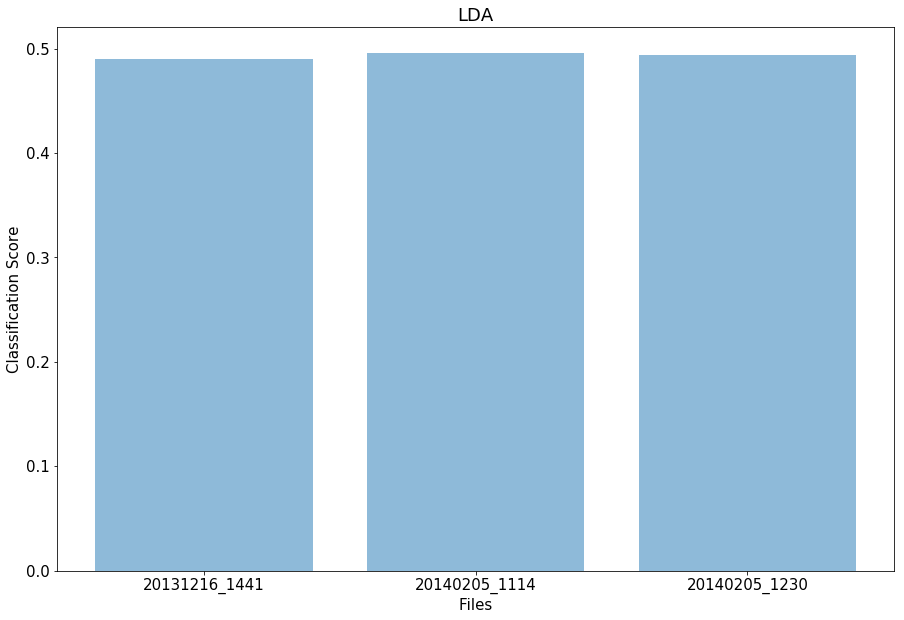

In [480]:
subj = ['20131216_1441','20140205_1114','20140205_1230']
pos = np.arange(len(subj))
plt.bar(pos, classification_score3, align='center', alpha=0.5)
plt.xticks(pos, subj)
plt.xlabel("Files")
plt.ylabel('Classification Score')
plt.title('LDA')